# Build BioMistral Medical RAG Chatbot using BioMistral Open Source LLM

In the notebook we will build a Medical Chatbot with BioMistral LLM and Medicare pdf file.


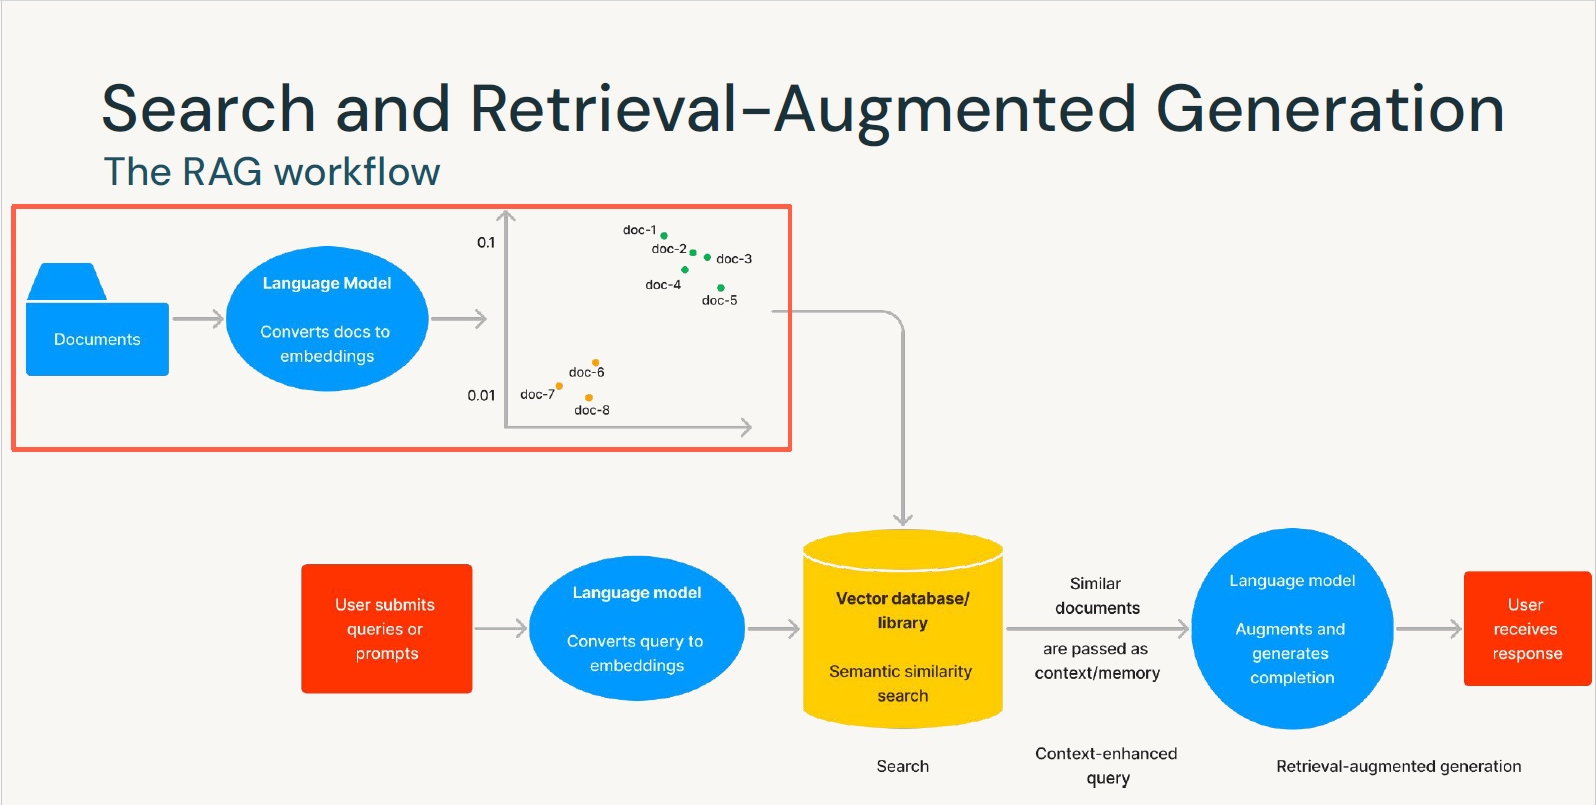

## Installation


In [1]:
!pip install langchain sentence-transformers chromadb llama-cpp-python langchain_community pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 13.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 11.6 MB/s eta 0:00:00
     ━

## Import libraries

In [2]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import CharacterTextSplitter,RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS, Chroma
from langchain_community.llms import LlamaCpp
from langchain.chains import RetrievalQA, LLMChain

In [3]:
import pathlib
import textwrap
from IPython.display import display
from IPython.display import Markdown



def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [4]:
# Used to securely store your API key
from google.colab import userdata

## Setup HuggingFace Access Token

- Log in to [HuggingFace.co](https://huggingface.co/)
- Click on your profile icon at the top-right corner, then choose [“Settings.”](https://huggingface.co/settings/)
- In the left sidebar, navigate to [“Access Token”](https://huggingface.co/settings/tokens)
- Generate a new access token, assigning it the “write” role.


In [5]:
# Or use `os.getenv('HUGGINGFACEHUB_API_TOKEN')` to fetch an environment variable.
import os
from getpass import getpass

HUGGINGFACEHUB_API_TOKEN = userdata.get("HUGGINGFACEHUB_API_TOKEN")
os.environ["HUGGINGFACEHUB_API_TOKEN"] = "HUGGINGFACEHUB_API_TOKEN"

## Import document


In [12]:
loader = PyPDFDirectoryLoader("/content/sample_data/Canadian_Healthcare_EMR")
docs = loader.load()

In [13]:
docs

[Document(page_content='Pan-Canadian Primary Health \nCare EMR Minimum Data Set for Performance Measurement\nVersion 1.1', metadata={'source': '/content/sample_data/Canadian_Healthcare_EMR/Canadian_Healthcare_EMR.pdf', 'page': 0}),
 Document(page_content='Production of this document is made possible by financial contributions from \nHealth Canada and provincial and territorial governments. The views expressed \nherein do not necessarily represent the views of Health Canada or any provincial \nor territorial government.\nAll rights reserved.\nThe contents of this publication may be reproduced unaltered, in whole or in part \nand by any means, solely for non-commercial purposes, provided that the Canadian \nInstitute for Health Information is properly and fully acknowledged as the copyright \nowner. Any reproduction or use of this publication or its contents for any commercial \npurpose requires the prior written authorization of the Canadian Institute for Health \nInformation. Reproduct

## Text Splitting - Chunking

In [64]:
chunk_size = 1000
overlap_percentage = 20  # Example overlap percentage
chunk_overlap = int(chunk_size * overlap_percentage / 100)
#splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, overlap=overlap)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
chunks = text_splitter.split_documents(docs)

In [65]:
len(chunks)

141

In [66]:
chunks[0]

Document(page_content='Pan-Canadian Primary Health \nCare EMR Minimum Data Set for Performance Measurement\nVersion 1.1', metadata={'source': '/content/sample_data/Canadian_Healthcare_EMR/Canadian_Healthcare_EMR.pdf', 'page': 0})

In [67]:
chunks[100]

Document(page_content='Pressure Number \n(data element E23) \nand Diastolic Blood \nPressure Number \n(data element \nE24). Performance \nmeasurement \nand reporting \nconsiderations \nto be determined.\nE27 Blood Pressure \nRepresentative \nReadingObservation \nRepresentative \nBlood Pressure \nReading CodeRepresents \nwhether the \nClient’s blood \npressure reading \nis representative of \nthe Client’s current \nhealth condition.Code n/a n/a SNOMED CT or \nother (jurisdictional \ncodes where \navailable)31874001\nTrue (qualifier value)\n(SNOMED CT)Can support the use \nof Systolic Blood \nPressure Number \n(data element E23) \nand Diastolic Blood \nPressure Number \n(data element \nE24). Performance \nmeasurement \nand reporting \nconsiderations \nto be determined.', metadata={'source': '/content/sample_data/Canadian_Healthcare_EMR/Canadian_Healthcare_EMR.pdf', 'page': 44})

## Embeddings

In [68]:
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Vector Store - FAISS or ChromaDB

In [69]:
vectorstore = Chroma.from_documents(chunks, embeddings)

In [70]:
vectorstore

In [71]:
query = "What is Canadian Institute for Health Information?"
search = vectorstore.similarity_search(query)

In [72]:
to_markdown(search[0].page_content)

> 5
> Pan-Canadian Primary Health Care EMR Minimum Data Set for Performance Measurement, Version 1.1
> About CIHI 
> The Canadian Institute for Health Information (CIHI) is an independent, not-for-profit 
> organization dedicated to providing essential health information to all Canadians. 
> CIHI works closely with federal, provincial and territorial partners and stakeholders throughout 
> Canada to gather, package and disseminate information to inform policy, management,

## Retriever

In [58]:
retriever = vectorstore.as_retriever(
    search_kwargs={'k':10}
)

In [73]:
retriever.get_relevant_documents(query)

[Document(page_content='5\nPan-Canadian Primary Health Care EMR Minimum Data Set for Performance Measurement, Version 1.1\nAbout CIHI \nThe Canadian Institute for Health Information (CIHI) is an independent, not-for-profit \norganization dedicated to providing essential health information to all Canadians. \nCIHI works closely with federal, provincial and territorial partners and stakeholders throughout \nCanada to gather, package and disseminate information to inform policy, management,', metadata={'page': 4, 'source': '/content/sample_data/Canadian_Healthcare_EMR/Canadian_Healthcare_EMR.pdf'}),
 Document(page_content='5\nPan-Canadian Primary Health Care EMR Minimum Data Set for Performance Measurement, Version 1.1\nAbout CIHI \nThe Canadian Institute for Health Information (CIHI) is an independent, not-for-profit \norganization dedicated to providing essential health information to all Canadians. \nCIHI works closely with federal, provincial and territorial partners and stakeholders 

## Large Language Model - Open Source

In [29]:
#connect to google drive
from google.colab import drive

In [30]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
llm = LlamaCpp(
    model_path= "/content/drive/MyDrive/LLM_Model/BioMistral-7B.Q4_K_M.gguf",
    temperature=0.6,
    max_tokens=2048,
    top_p=1)

llama_model_loader: loaded meta data with 21 key-value pairs and 291 tensors from /content/drive/MyDrive/LLM_Model/BioMistral-7B.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = hub
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.atte

## RAG Chain


In [32]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
from langchain.prompts import ChatPromptTemplate

In [74]:
template = """
<|context|>
You are an AI assistant that follows instruction extremely well.
Please be truthful and give direct answers
</s>
<|user|>
{query}
</s>
 <|assistant|>
"""

In [75]:
prompt = ChatPromptTemplate.from_template(template)

In [80]:
rag_chain = (
    {"context": retriever,  "query": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [81]:
response = rag_chain.invoke("What is Canadian Institute for Health Information?")


llama_print_timings:        load time =    3060.01 ms
llama_print_timings:      sample time =      39.43 ms /    56 runs   (    0.70 ms per token,  1420.38 tokens per second)
llama_print_timings: prompt eval time =   27663.24 ms /    60 tokens (  461.05 ms per token,     2.17 tokens per second)
llama_print_timings:        eval time =   38910.17 ms /    55 runs   (  707.46 ms per token,     1.41 tokens per second)
llama_print_timings:       total time =   66703.15 ms /   115 tokens


In [82]:
to_markdown(response)

> The Canadian Institute for Health Information (CIHI) is an independent, not-for-profit organization funded by all provincial and territorial governments in Canada. CIHI provides essential health data on health system performance, the health of Canadians, and the costs of healthcare.

In [83]:
import sys

while True:
  user_input = input(f"Input Prompt: ")
  if user_input == 'exit':
    print('Exiting')
    sys.exit()
  if user_input == '':
    continue
  result = rag_chain.invoke(user_input)
  print("Answer: ",result)

Input Prompt: What is Systematized Nomenclature of Medicine?


Llama.generate: prefix-match hit

llama_print_timings:        load time =    3060.01 ms
llama_print_timings:      sample time =      40.13 ms /    59 runs   (    0.68 ms per token,  1470.15 tokens per second)
llama_print_timings: prompt eval time =   10778.47 ms /    21 tokens (  513.26 ms per token,     1.95 tokens per second)
llama_print_timings:        eval time =   40514.33 ms /    58 runs   (  698.52 ms per token,     1.43 tokens per second)
llama_print_timings:       total time =   51411.07 ms /    79 tokens


Answer:  Systematized Nomenclature of Medicine, or SNOMED, is a system for coding medical concepts used in health information systems. It was developed by the College of American Pathologists and Health Level Seven International and is now managed by the International Health Care Technology Standards Development Organization .


KeyboardInterrupt: Interrupted by user